In [8]:
import torch                                                # PyTorch main package for tensor operations and deep learning
import torch.nn as nn                                       # PyTorch module for building neural network layers
import torch.optim as optim                                 # PyTorch module for optimization algorithms (e.g., Adam, SGD)
import sacrebleu                                            # Library for calculating BLEU score (translation quality metric)
from torchtext.data.utils import get_tokenizer              # Utility to get tokenizers for text preprocessing
from torchtext.vocab import build_vocab_from_iterator       # Function to build vocabulary from tokenized data
from torchtext.datasets import Multi30k                     # Multi30k dataset for English-German/French translation tasks
from typing import Tuple                                    # Type hinting for functions that return tuples
import spacy                                                # NLP library for tokenization and linguistic features
import warnings
warnings.filterwarnings("ignore")



In [9]:
print(torch.__version__)                #check the version of pytorch

2.1.0


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Initializes the MultiHeadSelfAttention module.

        Args:
        d_model (int): Total dimension of the model.
        num_heads (int): Number of attention heads.
        """
        super(MultiHeadSelfAttention, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        # Ensure the model dimension is divisible by number of heads
        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads"

        # Linear layers to project input into Q, K, V
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        # Final linear layer after concatenating attention output from all heads
        self.wo = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        Forward pass for MultiHeadSelfAttention.

        Args:
        q (Tensor): Query tensor of shape (batch_size, seq_length, d_model).
        k (Tensor): Key tensor of shape (batch_size, seq_length, d_model).
        v (Tensor): Value tensor of shape (batch_size, seq_length, d_model).
        mask (Tensor, optional): Mask tensor. Defaults to None.

        Returns:
        Tensor: Output tensor of shape (batch_size, seq_length, d_model).
        """
        batch_size = q.size(0)

        # Apply linear layers and split into multiple heads
        # Output shape: (batch_size, num_heads, seq_length, head_dim)
        q = self.wq(q).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.wk(k).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.wv(v).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # shape: (batch_size, num_heads, seq_length, seq_length)

        if mask is not None:
            # Apply mask (e.g., for causal or padding attention)
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)  # Normalize over keys
        attn_output = torch.matmul(attn_weights, v)    # shape: (batch_size, num_heads, seq_length, head_dim)

        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # Final linear projection
        out = self.wo(attn_output)

        return out


### Multi-head self-attention splits the input into multiple attention "heads" to learn different patterns.
### Queries, Keys, and Values are projected from the same input using linear layers.
### Scaled dot-product attention is applied to compute weighted representations.
### All heads are concatenated and passed through a final linear projection to get the final output.

# Position- wise Feed Forward Networks

In [11]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout = 0.1):
        """
        Initialize the PositionwiseFeedForward module.
        
        Args:
        d_model (int): The dimensionality of the input.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """
        super(PositionwiseFeedForward,self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self,x):
        """
        Forward pass for PositionwiseFeedForward.
        
        Args:
        x (Tensor): The input tensor of shape (batch_size, seq_length, d_model).
        
        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """

        out = self.linear1(x)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)

        return out



# Add and Norm

In [12]:
class AddNorm(nn.Module):
    def __init__(self, d_model, eps =1e-6):
        """
        Initialize the AddNorm module.

        Args:
        d_model (int): The dimensionality of the input.
        eps (float, optional): A small constant for numerical stability. Defaults to 1e-6.
        """
        super(AddNorm,self).__init__()
        self.norm = nn.LayerNorm(d_model,eps = eps)

    
    def forward(self,x,residual):
        """
        Forward pass for AddNorm.

        Args:
        x (Tensor): The input tensor of shape (batch_size, seq_length, d_model).
        residual (Tensor): The residual tensor of the same shape as the input tensor.

        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """

        out = x +residual
        out = self.norm(out)

        return out


#  Positional Encoding

In [13]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len, dropout = 0.1):
        """
        Initialize the PositionalEncoding module.

        Args:
        d_model (int): The dimensionality of the input.
        max_seq_len (int): The maximum length of the input sequence.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """

        super(PositionalEncoding,self).__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_len,d_model)
        position = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model,2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Forward pass for PositionalEncoding.

        Args:
        x (Tensor): The input tensor of shape (batch_size, seq_length, d_model).

        Returns:
        Tensor: The output tensor of shape (batch_size, seq_length, d_model).
        """

        x = x + self.pe[:, :x.size(1), :]
        x = self.dropout(x)

        return x
            



## Encoder Block

The Encoder Block in the Transformer architecture consists of the following layers:

- Multi-Head Self-Attention layer
- Add & Norm (Residual connection and Layer Normalization)
- Position-wise Feed-Forward Network layer
- Add & Norm (Residual connection and Layer Normalization)

In the Transformer, multiple encoder blocks (6 according to the paper) are stacked on top of each other to form the complete encoder module.

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self,d_model,num_heads,d_ff, dropout = 0.1):
        """
        Initialize the EncoderBlock module.

        Args:
        d_model (int): The dimensionality of the input.
        num_heads (int): The number of attention heads.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """

        super(EncoderBlock,self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model,num_heads)
        self.norm1 = AddNorm(d_model)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm2 = AddNorm(d_model)


    def forward(self, x , mask = None):
        x1 = self.self_attn(x,x,x,mask)
        x = self.norm1(x,x1)
        x1 = self.ffn(x)
        x = self.norm2(x,x1)

        return x


## Decoder

The Decoder Block in the Transformer architecture consists of the following layers:

- Masked Multi-Head Self-Attention layer
- Add & Norm (Residual connection and Layer Normalization)
- Encoder-Decoder Multi-Head Attention layer
- Add & Norm (Residual connection and Layer Normalization)
- Position-wise Feed-Forward Network layer
- Add & Norm (Residual connection and Layer Normalization)

In the Transformer, multiple decoder blocks are stacked on top of each other to form the complete decoder module.

In [15]:

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initializes the DecoderBlock module.

        Args:
        d_model (int): The dimensionality of the input.
        num_heads (int): The number of attention heads.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        dropout (float): The dropout probability.
        """
        super(DecoderBlock, self).__init__()

        # 1. Masked Multi-Head Self-Attention (causal)
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = AddNorm(d_model)

        # 2. Encoder-Decoder Multi-Head Attention
        self.enc_dec_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm2 = AddNorm(d_model)

        # 3. Feed Forward Network
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm3 = AddNorm(d_model)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        """
        Forward pass for DecoderBlock.

        Args:
        x (Tensor): Target sequence input (batch_size, tgt_seq_len, d_model)
        enc_output (Tensor): Encoder output (batch_size, src_seq_len, d_model)
        src_mask (Tensor, optional): Encoder mask. Shape (batch_size, 1, 1, src_seq_len)
        tgt_mask (Tensor, optional): Decoder mask. Shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        Returns:
        Tensor: Output tensor (batch_size, tgt_seq_len, d_model)
        """
        # 1. Masked Self-Attention with target mask
        attn1 = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x, attn1)  # Residual + LayerNorm

        # 2. Encoder-Decoder Attention with source mask
        attn2 = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x, attn2)

        # 3. Feed Forward Network
        ffn_out = self.ffn(x)
        x = self.norm3(x, ffn_out)

        return x


## The Transformer

Now that we have implemented all the building blocks, let's assemble the complete Transformer architecture.

We initialize the following components:

- Source and target embedding layers
- Positional encoding module
- Encoder and decoder layer stacks
- Final linear layer to produce the probability distribution over the target vocabulary

In the forward method, we first pass the source and target input tensors through their respective embedding layers and add the positional encoding. Then, we pass the source input through each encoder layer sequentially, followed by passing the target input and encoder output through each decoder layer sequentially. Finally, we apply the linear layer to produce the output tensor with shape (batch_size, tgt_seq_length, tgt_vocab_size).

In [16]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, D_MODEL, num_heads, d_ff, max_seq_len, num_layers, dropout=0.1):
        """
        Initialize the Transformer module.

        Args:
        src_vocab_size (int): The size of the source vocabulary.
        tgt_vocab_size (int): The size of the target vocabulary.
        d_model (int): The dimensionality of the embedding
        num_heads (int): The number of attention heads.
        d_ff (int): The dimensionality of the hidden layer in the feed-forward network.
        max_seq_len (int): The maximum length of the input sequence.
        num_layers (int): The number of layers in the encoder and decoder.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        """
        super(Transformer, self).__init__()

        self.src_embedding = nn.Embedding(src_vocab_size, D_MODEL)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, D_MODEL)
        self.pos_encoding = PositionalEncoding(D_MODEL, max_seq_len, dropout)

        self.encoder_layers = nn.ModuleList([EncoderBlock(D_MODEL, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderBlock(D_MODEL, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(D_MODEL, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Forward pass for Transformer.

        Args:
        src (Tensor): The source input tensor of shape (batch_size, src_seq_length).
        tgt (Tensor): The target input tensor of shape (batch_size, tgt_seq_length).
        src_mask (Tensor, optional): The source mask tensor for ignoring certain elements. Defaults to None.
        tgt_mask (Tensor, optional): The target mask tensor for ignoring certain elements. Defaults to None.

        Returns:
        Tensor: The output tensor of shape (batch_size, tgt_seq_length, tgt_vocab_size).
        """
        src = self.src_embedding(src)
        src = self.pos_encoding(src)

        tgt = self.tgt_embedding(tgt)
        tgt = self.pos_encoding(tgt)

        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        for layer in self.decoder_layers:
            tgt = layer(tgt, src, src_mask, tgt_mask)

        out = self.fc(tgt)

        return out

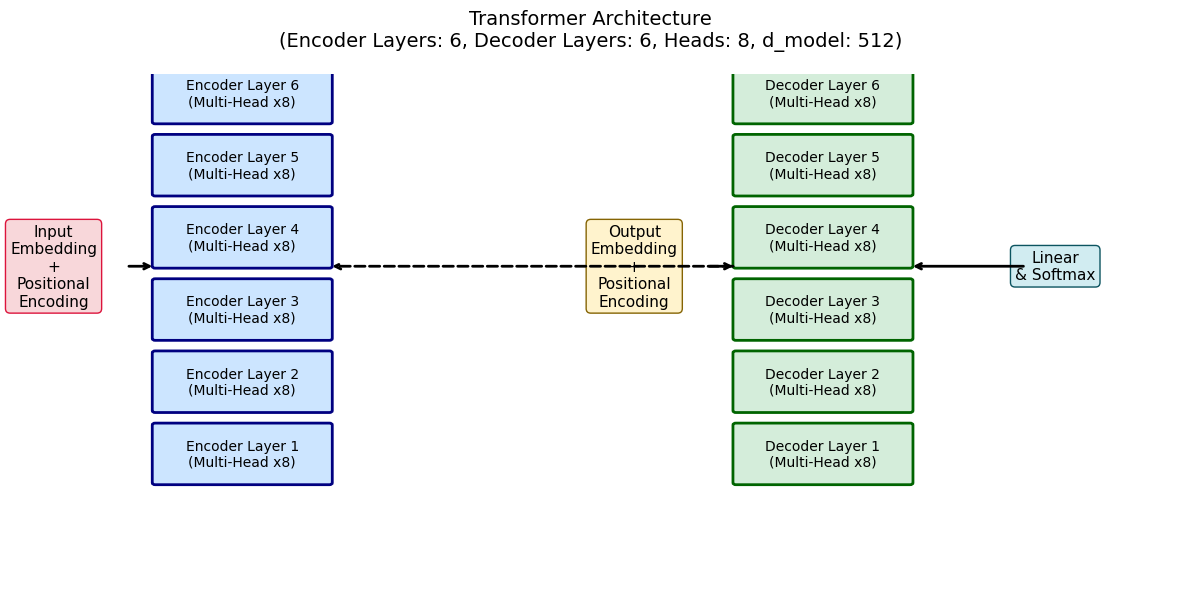

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_transformer(num_encoder_layers, num_decoder_layers, num_heads, d_model):
    """
    Visualizes a high-level architecture of the Transformer model.

    Args:
        num_encoder_layers (int): Number of encoder layers.
        num_decoder_layers (int): Number of decoder layers.
        num_heads (int): Number of attention heads.
        d_model (int): Embedding dimension.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')

    # Encoder blocks
    encoder_x = 1
    encoder_y_start = 1
    encoder_height = 0.6
    encoder_gap = 0.15
    for i in range(num_encoder_layers):
        rect = mpatches.FancyBboxPatch(
            (encoder_x, encoder_y_start + i * (encoder_height + encoder_gap)),
            1.2, encoder_height,
            boxstyle="round,pad=0.02",
            edgecolor='navy', facecolor='#cce5ff', linewidth=2
        )
        ax.add_patch(rect)
        ax.text(encoder_x + 0.6, encoder_y_start + i * (encoder_height + encoder_gap) + encoder_height/2,
                f'Encoder Layer {i+1}\n(Multi-Head x{num_heads})', ha='center', va='center', fontsize=10)

    # Decoder blocks
    decoder_x = 5
    decoder_y_start = 1
    decoder_height = 0.6
    decoder_gap = 0.15
    for i in range(num_decoder_layers):
        rect = mpatches.FancyBboxPatch(
            (decoder_x, decoder_y_start + i * (decoder_height + decoder_gap)),
            1.2, decoder_height,
            boxstyle="round,pad=0.02",
            edgecolor='darkgreen', facecolor='#d4edda', linewidth=2
        )
        ax.add_patch(rect)
        ax.text(decoder_x + 0.6, decoder_y_start + i * (decoder_height + decoder_gap) + decoder_height/2,
                f'Decoder Layer {i+1}\n(Multi-Head x{num_heads})', ha='center', va='center', fontsize=10)

    # Embedding and Positional Encoding
    ax.text(encoder_x - 0.7, encoder_y_start + (num_encoder_layers * (encoder_height + encoder_gap))/2,
            'Input\nEmbedding\n+\nPositional\nEncoding', ha='center', va='center', fontsize=11, bbox=dict(boxstyle="round", fc="#f8d7da", ec="crimson"))
    ax.text(decoder_x - 0.7, decoder_y_start + (num_decoder_layers * (decoder_height + decoder_gap))/2,
            'Output\nEmbedding\n+\nPositional\nEncoding', ha='center', va='center', fontsize=11, bbox=dict(boxstyle="round", fc="#fff3cd", ec="#856404"))

    # Output Linear Layer
    ax.text(decoder_x + 2.2, decoder_y_start + (num_decoder_layers * (decoder_height + decoder_gap))/2,
            'Linear\n& Softmax', ha='center', va='center', fontsize=11, bbox=dict(boxstyle="round", fc="#d1ecf1", ec="#0c5460"))

    # Arrows: Input -> Encoder
    ax.annotate('', xy=(encoder_x, encoder_y_start + (num_encoder_layers * (encoder_height + encoder_gap))/2),
                xytext=(encoder_x - 0.2, encoder_y_start + (num_encoder_layers * (encoder_height + encoder_gap))/2),
                arrowprops=dict(facecolor='black', arrowstyle='->', lw=2))

    # Arrows: Encoder -> Decoder (cross attention)
    ax.annotate('', xy=(encoder_x + 1.2, encoder_y_start + (num_encoder_layers * (encoder_height + encoder_gap))/2),
                xytext=(decoder_x, decoder_y_start + (num_decoder_layers * (decoder_height + decoder_gap))/2),
                arrowprops=dict(facecolor='gray', arrowstyle='->', lw=2, linestyle='dashed'))

    # Arrows: Output Embedding -> Decoder
    ax.annotate('', xy=(decoder_x, decoder_y_start + (num_decoder_layers * (decoder_height + decoder_gap))/2),
                xytext=(decoder_x - 0.2, decoder_y_start + (num_decoder_layers * (decoder_height + decoder_gap))/2),
                arrowprops=dict(facecolor='black', arrowstyle='->', lw=2))

    # Arrows: Decoder -> Linear
    ax.annotate('', xy=(decoder_x + 1.2, decoder_y_start + (num_decoder_layers * (decoder_height + decoder_gap))/2),
                xytext=(decoder_x + 2.0, decoder_y_start + (num_decoder_layers * (decoder_height + decoder_gap))/2),
                arrowprops=dict(facecolor='black', arrowstyle='->', lw=2))

    # Title and legend
    ax.set_title(f"Transformer Architecture\n(Encoder Layers: {num_encoder_layers}, Decoder Layers: {num_decoder_layers}, Heads: {num_heads}, d_model: {d_model})", fontsize=14, pad=20)
    plt.xlim(0, 8)
    plt.ylim(0, 3 + max(num_encoder_layers, num_decoder_layers) * (encoder_height + encoder_gap) / 2)
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_transformer(num_encoder_layers=6, num_decoder_layers=6, num_heads=8, d_model=512)


This image illustrates the **Transformer Architecture**, a foundational model used in many modern NLP systems such as BERT, GPT, and T5. It visualizes how information flows through the **encoder-decoder structure** of a transformer.

Let’s break it down **intuitively and step by step**:

---

## 🧠 High-Level Summary

* The **left side** is the **Encoder**, which reads and understands the input.
* The **right side** is the **Decoder**, which generates the output (like a translated sentence).
* In between, the encoder and decoder **communicate** using attention mechanisms.
* The **transformer uses 8 attention heads** and **6 stacked layers** in both encoder and decoder, with a model dimension (`d_model`) of 512.

---

## 🔴 Step 1: Input Embedding + Positional Encoding

* Each word/token in the input sequence is **converted to a dense vector (embedding)**.
* Since transformers don’t understand order, **positional encoding** is added to inject the notion of word order (e.g., who comes first in the sentence).

📦 Example:

> `"I love transformers"` → becomes a matrix of shape `(seq_len, 512)`.

---

## 🔵 Encoder Stack (Left Side)

There are **6 identical encoder layers**, each with:

1. **Multi-head self-attention**
   → Every word looks at every other word (including itself) to understand context.

   > e.g., “bank” can mean money or river — attention helps disambiguate it by context.

2. **Feedforward network**
   → A small neural network to refine each word’s representation.

3. **Residual connections + LayerNorm**
   → Helps in stabilizing training and preserving input signals.

📌 Output: A context-enriched representation for each word.

---

## 🟡 Output Embedding + Positional Encoding

This is for the **decoder input** (often previous tokens during training or inference).

* The decoder also needs **positional info**.
* It uses **shifted right** sequences during training (i.e., we don't feed the full output at once, only up to the current word).

---

## 🟢 Decoder Stack (Right Side)

Also has **6 layers**, and each contains:

1. **Masked Multi-head self-attention**
   → Each position can only attend to previous tokens (to prevent cheating during generation).

2. **Encoder-Decoder attention**
   → The decoder attends to encoder outputs — this is how the decoder knows what the input meant.

3. **Feedforward network**
   → Like in the encoder, applies transformation to each position.

Each layer builds a **richer representation** of the output sequence being generated.

---

## 🔷 Final Step: Linear + Softmax

* After decoder layers, the final output goes through a **linear layer** followed by **softmax** to predict the next word.
* This output is a probability distribution over the vocabulary.

---

## 🔁 Example: English to French Translation

```text
Input: "I love transformers"
↓
Encoder processes this and creates contextual embeddings
↓
Decoder begins with: "<start>" token
↓
Decoder predicts "J'"
↓
Then uses "J'" + context to predict "aime"
↓
Repeats until "<end>" is generated
```

---

## ⚙️ Config Summary (from diagram):

* `Encoder Layers: 6`
* `Decoder Layers: 6`
* `Heads: 8` (each layer has 8 attention heads)
* `d_model: 512` (embedding size)



In [17]:
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import Multi30k
from collections import Counter
from tqdm import tqdm
import spacy
import sys
import subprocess

def ensure_spacy_model(model_name):
    try:
        spacy.load(model_name)
    except OSError:
        print(f"Downloading spaCy model '{model_name}'...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])

# Ensure required spaCy models are installed
ensure_spacy_model("en_core_web_sm")
ensure_spacy_model("de_core_news_sm")

en_tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
de_tokenizer = get_tokenizer("spacy", language="de_core_news_sm")

def tokenize_en(text):
    return en_tokenizer(str(text))

def tokenize_de(text):
    return de_tokenizer(str(text))

# --- FIXED DATA LOADING ---
train_iter = Multi30k(split='train', language_pair=('en', 'de'))
train_data_en = []
train_data_de = []
for en, de in train_iter:
    train_data_en.append(en)
    train_data_de.append(de)
# --- END FIX ---

class VOCAB:
    def __init__(self, tokenizer, min_freq=2, data=None, special_tokens=['<pad>', '<sos>', '<eos>', '<unk>']):
        self.tokenizer = tokenizer
        self.min_freq = min_freq
        self.special_tokens = special_tokens
        self.build_vocab(data)

    def build_vocab(self, data):
        counter = Counter()
        for text in tqdm(data, desc="Building vocab"):
            tokens = self.tokenizer(text)
            counter.update(tokens)
        tokens = [token for token, freq in counter.items() if freq >= self.min_freq and token not in self.special_tokens]
        tokens = self.special_tokens + tokens
        self.stoi = {token: index for index, token in enumerate(tokens)}
        self.itos = tokens

    def __len__(self):
        return len(self.stoi)

    def __getitem__(self, token):
        return self.stoi.get(token, self.stoi['<unk>'])

EN_VOCAB = VOCAB(tokenize_en, min_freq=1, data=train_data_en)
DE_VOCAB = VOCAB(tokenize_de, min_freq=1, data=train_data_de)
print("\nVocab Size English", len(EN_VOCAB))
print("\nVocab Size German", len(DE_VOCAB))

Building vocab: 100%|██████████| 29001/29001 [00:01<00:00, 15855.42it/s]


Vocab Size English 10837

Vocab Size German 19214



This code prepares bilingual text data (English ↔ German) for a machine translation model using the **Multi30k dataset**.

Here's what it does:

* ✅ **Loads English–German sentence pairs** using `torchtext`.
* 🧠 **Tokenizes** the sentences using **spaCy**, a language-aware tokenizer that handles grammar, punctuation, and morphology.
* 📦 **Builds vocabularies** for both languages:

  * Assigns each token a unique index.
  * Includes special tokens like `<pad>`, `<sos>`, `<eos>`, and `<unk>`.
  * Filters out rare words (optional via `min_freq`).
* 🔢 The final output is a mapping from words → numbers, which is essential for training neural networks.

This setup forms the **first step in building a translation model**—converting raw text into something a neural model can understand and learn from.


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class TranslationDataset(Dataset):
    def __init__(self, en_data, de_data, src_tokenizer, tgt_tokenizer, src_vocab, tgt_vocab):
        """
        Initialize the dataset with source (English) and target (German) data,
        along with their respective tokenizers and vocabularies.
        """
        self.en_data = en_data  # List of English sentences
        self.de_data = de_data  # List of German sentences
        self.src_tokenizer = src_tokenizer  # Tokenizer for English
        self.tgt_tokenizer = tgt_tokenizer  # Tokenizer for German
        self.src_vocab = src_vocab  # English vocabulary (token -> index)
        self.tgt_vocab = tgt_vocab  # German vocabulary (token -> index)

    def __getitem__(self, index):
        """
        Process a single (English, German) sentence pair:
        - Tokenize
        - Convert tokens to indices
        - Add <sos> and <eos> special tokens
        - Return tensors for both source and target
        """
        src_txt, tgt_txt = self.en_data[index], self.de_data[index]

        # Tokenize and convert to indices using vocab
        src_tokens = [self.src_vocab[token] for token in self.src_tokenizer(src_txt)]
        tgt_tokens = [self.tgt_vocab[token] for token in self.tgt_tokenizer(tgt_txt)]

        # Add <sos> and <eos> tokens around the sequences
        src_tokens = [self.src_vocab['<sos>']] + src_tokens + [self.src_vocab['<eos>']]
        tgt_tokens = [self.tgt_vocab['<sos>']] + tgt_tokens + [self.tgt_vocab['<eos>']]

        # Convert to PyTorch tensors
        src_tensor = torch.LongTensor(src_tokens)
        tgt_tensor = torch.LongTensor(tgt_tokens)

        return src_tensor, tgt_tensor

    def __len__(self):
        """
        Return the total number of sentence pairs in the dataset.
        """
        assert len(self.en_data) == len(self.de_data)  # Ensure aligned data
        return len(self.en_data)

    def collate_fn(self, batch):
        """
        Custom function to pad batches of variable-length sequences:
        - Pads all source and target tensors in the batch to the same length
        - Uses <pad> token index from vocab
        - Returns two padded tensors (src_batch, tgt_batch)
        """
        src_tensors, tgt_tensors = zip(*batch)  # Unzip list of (src, tgt) pairs

        # Pad sequences to match longest in batch (for batching)
        src_tensors = torch.nn.utils.rnn.pad_sequence(
            src_tensors, padding_value=self.src_vocab['<pad>'], batch_first=True
        )
        tgt_tensors = torch.nn.utils.rnn.pad_sequence(
            tgt_tensors, padding_value=self.tgt_vocab['<pad>'], batch_first=True
        )

        return src_tensors, tgt_tensors


In [19]:
# Use the correct Multi30k data folder and file names as per the multi30k_data folder and the 2016 split

import gzip

def read_gzipped_lines(filepath):
    with gzip.open(filepath, "rt", encoding="utf-8") as f:
        return [line.strip() for line in f]

# Paths to gzipped files in the multi30k_data folder
train_en_file = "multi30k/train.en.gz"
train_de_file = "multi30k/train.de.gz"
val_en_file   = "multi30k/val.en.gz"
val_de_file   = "multi30k/val.de.gz"
test_en_file  = "multi30k/test_2016_flickr.en.gz"
test_de_file  = "multi30k/test_2016_flickr.de.gz"

# Read the data from gzipped files
train_data_en = read_gzipped_lines(train_en_file)
train_data_de = read_gzipped_lines(train_de_file)
val_data_en   = read_gzipped_lines(val_en_file)
val_data_de   = read_gzipped_lines(val_de_file)
test_data_en  = read_gzipped_lines(test_en_file)
test_data_de  = read_gzipped_lines(test_de_file)

train_dataset = TranslationDataset(train_data_en, train_data_de, tokenize_en, tokenize_de, EN_VOCAB, DE_VOCAB)
val_dataset = TranslationDataset(val_data_en, val_data_de, tokenize_en, tokenize_de, EN_VOCAB, DE_VOCAB)
test_dataset = TranslationDataset(test_data_en, test_data_de, tokenize_en, tokenize_de, EN_VOCAB, DE_VOCAB)

BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=val_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_dataset.collate_fn)